## Criação de Data Lake e Data Lakehouse
**Esse notebook foi desenvolvido na plataforma Databricks utilizando Spark para criação do ambiente Big Data**

### Dados da empresa fictícia Northwind
**Os dados foram obtidos do banco de dados relacional da empresa e convertidos em CSV**  
**O diagrama do data warehouse está na seção 6.1**

### 1 Criar pasta no FileStore para subir os CSVs gerados do Banco de Dados Relacional

In [0]:
diretoio_csvs = 'FileStore/Northwind_CSVs/'

In [0]:
# Cria o diretório no FileStore para subir os CSVs
dbutils.fs.mkdirs(diretoio_csvs)

Out[44]: True

### 2 Subir manualmente os CSVs para a pasta criada

In [0]:
display(dbutils.fs.ls(diretoio_csvs))

path,name,size,modificationTime
dbfs:/FileStore/Northwind_CSVs/categories.csv,categories.csv,436,1651860404000
dbfs:/FileStore/Northwind_CSVs/customer_customer_demo.csv,customer_customer_demo.csv,30,1651860404000
dbfs:/FileStore/Northwind_CSVs/customer_demographics.csv,customer_demographics.csv,32,1651860405000
dbfs:/FileStore/Northwind_CSVs/customers.csv,customers.csv,11655,1651860406000
dbfs:/FileStore/Northwind_CSVs/employee_territories.csv,employee_territories.csv,467,1651860406000
dbfs:/FileStore/Northwind_CSVs/employees.csv,employees.csv,4080,1651860407000
dbfs:/FileStore/Northwind_CSVs/order_details.csv,order_details.csv,42781,1651860407000
dbfs:/FileStore/Northwind_CSVs/orders.csv,orders.csv,99362,1651860408000
dbfs:/FileStore/Northwind_CSVs/products.csv,products.csv,4417,1651860408000
dbfs:/FileStore/Northwind_CSVs/region.csv,region.csv,76,1651860409000


### 3 Configurar e criar o data lake

In [0]:
username = 'lucasperuzzo'
northwind = f"/letscode/{username}/"

spark.sql(f"CREATE DATABASE IF NOT EXISTS letscode_{username}")
spark.sql(f"USE letscode_{username}")

Out[46]: DataFrame[]

In [0]:
# Limpeza para rodar outras tentativas
dbutils.fs.rm(northwind+'raw', recurse = True)

Out[47]: True

### 4 Camada RAW

In [0]:
lista_path_raw = [] #lista de tuplas, cada tupla composta pelo diretório RAW e o nome de cada arquivo
for csv in dbutils.fs.ls(diretoio_csvs):
    diretorio_raw = northwind + 'raw/' + csv.name[0:csv.name.find('.csv')] + '/'  #Diretório RAW onde serão copiados os arquivos CSVs
    dbutils.fs.cp(diretoio_csvs + csv.name, diretorio_raw + csv.name)
    assert csv.name in [item.name for item in dbutils.fs.ls(diretorio_raw)], f"O arquivo {csv.name} não foi encontrado na pasta {diretorio_raw}"
    lista_path_raw.append((diretorio_raw , csv.name))
    
display(dbutils.fs.ls(northwind+'/raw'))

path,name,size,modificationTime
dbfs:/letscode/lucasperuzzo/raw/categories/,categories/,0,0
dbfs:/letscode/lucasperuzzo/raw/customer_customer_demo/,customer_customer_demo/,0,0
dbfs:/letscode/lucasperuzzo/raw/customer_demographics/,customer_demographics/,0,0
dbfs:/letscode/lucasperuzzo/raw/customers/,customers/,0,0
dbfs:/letscode/lucasperuzzo/raw/employee_territories/,employee_territories/,0,0
dbfs:/letscode/lucasperuzzo/raw/employees/,employees/,0,0
dbfs:/letscode/lucasperuzzo/raw/order_details/,order_details/,0,0
dbfs:/letscode/lucasperuzzo/raw/orders/,orders/,0,0
dbfs:/letscode/lucasperuzzo/raw/products/,products/,0,0
dbfs:/letscode/lucasperuzzo/raw/region/,region/,0,0


### 5 Camada TRUSTED

In [0]:
dataframes = {}  #dicionario de dataframes gerados pela leitura dos CSVs
lista_tabelas = []
for item in lista_path_raw:
    nome_tabela = item[1][0:item[1].find('.csv')]
    lista_tabelas.append(nome_tabela)
    dataframes[nome_tabela] = spark.read.csv(item[0]+item[1], header="true")
    
lista_tabelas

Out[49]: ['categories',
 'customer_customer_demo',
 'customer_demographics',
 'customers',
 'employee_territories',
 'employees',
 'order_details',
 'orders',
 'products',
 'region',
 'shippers',
 'suppliers',
 'territories',
 'us_states']

#### 5.1 Trasformações nas tabelas

In [0]:
from pyspark.sql.functions import col
dfs_processados = {} #dicionario de dataframes depois de estarem com os dados "confiáveis"

#### 5.1.1 'categories'

In [0]:
display(dataframes['categories'].head(2))
display(dataframes['categories'].dtypes)

category_id,category_name,description,picture
1,Beverages,"Soft drinks, coffees, teas, beers, and ales",\x
2,Condiments,"Sweet and savory sauces, relishes, spreads, and seasonings",\x


_1,_2
category_id,string
category_name,string
description,string
picture,string


In [0]:
def processa_categories(dataframe):
    return (
        dataframe
        .select(
            col("category_id").cast("integer"),
            "category_name",
            "description",
            "picture"
        )
    )

dfs_processados['categories'] = processa_categories(dataframes['categories'])
display(dfs_processados['categories'].dtypes)

_1,_2
category_id,int
category_name,string
description,string
picture,string


#### 5.1.2 'customer_customer_demo'

In [0]:
display(dataframes['customer_customer_demo'])

customer_id,customer_type_id


#### 5.1.2 'customer_demographics'

In [0]:
display(dataframes['customer_demographics'])

customer_type_id,customer_desc


As tabelas "customer_customer_demo.csv" e "customer_demographics.csv" não serão criadas nos dados Trusted por estarem vazias.

In [0]:
lista_tabelas.remove('customer_customer_demo')
lista_tabelas.remove('customer_demographics')

#### 5.1.4 'customers'

In [0]:
display(dataframes['customers'])
display(dataframes['customers'].dtypes)

customer_id,company_name,contact_name,contact_title,address,city,region,postal_code,country,phone,fax
ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,null,12209,Germany,030-0074321,030-0076545
ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,null,05021,Mexico,(5) 555-4729,(5) 555-3745
ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,null,05023,Mexico,(5) 555-3932,null
AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,null,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,null,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,null,68306,Germany,0621-08460,0621-08924
BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,null,67000,France,88.60.15.31,88.60.15.32
BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,null,28023,Spain,(91) 555 22 82,(91) 555 91 99
BONAP,Bon app',Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,null,13008,France,91.24.45.40,91.24.45.41
BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,BC,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


_1,_2
customer_id,string
company_name,string
contact_name,string
contact_title,string
address,string
city,string
region,string
postal_code,string
country,string
phone,string


In [0]:
# sem necessidade de corrigir algum tipo de dado
dfs_processados['customers'] = dataframes['customers']

#### 5.1.5 'employee_territories'

In [0]:
display(dataframes['employee_territories'].head(2))
display(dataframes['employee_territories'].dtypes)

employee_id,territory_id
1,06897
1,19713


_1,_2
employee_id,string
territory_id,string


In [0]:
def employee_territories(dataframe):
    return (
        dataframe
        .select(
            col("employee_id").cast("integer"),
            col("territory_id").cast("integer")
        )
    )

dfs_processados['employee_territories'] = employee_territories(dataframes['employee_territories'])
display(dfs_processados['employee_territories'].dtypes)

_1,_2
employee_id,int
territory_id,int


#### 5.1.6 'employees'

In [0]:
display(dataframes['employees'].head(2))
display(dataframes['employees'].dtypes)

employee_id,last_name,first_name,title,title_of_courtesy,birth_date,hire_date,address,city,region,postal_code,country,home_phone,extension,photo,notes,reports_to,photo_path
1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.\nApt. 2A,Seattle,WA,98122,USA,(206) 555-9857,5467,\x,Education includes a BA in psychology from Colorado State University in 1970. She also completed The Art of the Cold Call. Nancy is a member of Toastmasters International.,2,http://accweb/emmployees/davolio.bmp
2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,1992-08-14,908 W. Capital Way,Tacoma,WA,98401,USA,(206) 555-9482,3457,\x,"Andrew received his BTS commercial in 1974 and a Ph.D. in international marketing from the University of Dallas in 1981. He is fluent in French and Italian and reads German. He joined the company as a sales representative, was promoted to sales manager in January 1992 and to vice president of sales in March 1993. Andrew is a member of the Sales Management Roundtable, the Seattle Chamber of Commerce, and the Pacific Rim Importers Association.",null,http://accweb/emmployees/fuller.bmp


_1,_2
employee_id,string
last_name,string
first_name,string
title,string
title_of_courtesy,string
birth_date,string
hire_date,string
address,string
city,string
region,string


In [0]:
def employees(dataframe):
    return (
        dataframe
        .select(
            col("employee_id").cast("integer"),
            "last_name",
            "first_name",
            "title",
            "title_of_courtesy",
            col("birth_date").cast("date"),
            col("hire_date").cast("date"),
            "address",
            "city",
            "region",
            "postal_code",
            "country",
            "home_phone",
            "extension",
            "photo",
            "notes",
            "reports_to",
            "photo_path" 
        )
    )
    
dfs_processados['employees'] = employees(dataframes['employees'])
display(dfs_processados['employees'].dtypes)

_1,_2
employee_id,int
last_name,string
first_name,string
title,string
title_of_courtesy,string
birth_date,date
hire_date,date
address,string
city,string
region,string


#### 5.1.7 'order_details'

In [0]:
display(dataframes['order_details'].head(2))
display(dataframes['order_details'].dtypes)

order_id,product_id,unit_price,quantity,discount
10248,11,14,12,0
10248,42,9.8,10,0


_1,_2
order_id,string
product_id,string
unit_price,string
quantity,string
discount,string


In [0]:
def order_details(dataframe):
    return (
        dataframe
        .select(
            col("order_id").cast("integer"),
            col("product_id").cast("integer"),
            col("unit_price").cast("float"),
            col("quantity").cast("integer"),
            col("discount").cast("float")
        )
    )
    
dfs_processados['order_details'] = order_details(dataframes['order_details'])
display(dfs_processados['order_details'].dtypes)

_1,_2
order_id,int
product_id,int
unit_price,float
quantity,int
discount,float


#### 5.1.8 'orders'

In [0]:
display(dataframes['orders'])
display(dataframes['orders'].dtypes)

order_id,customer_id,employee_id,order_date,required_date,shipped_date,ship_via,freight,ship_name,ship_address,ship_city,ship_region,ship_postal_code,ship_country
10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,null,51100,France
10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,null,44087,Germany
10250,HANAR,4,1996-07-08,1996-08-05,1996-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
10251,VICTE,3,1996-07-08,1996-08-05,1996-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,null,69004,France
10252,SUPRD,4,1996-07-09,1996-08-06,1996-07-11,2,51.3,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,null,B-6000,Belgium
10253,HANAR,3,1996-07-10,1996-07-24,1996-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
10254,CHOPS,5,1996-07-11,1996-08-08,1996-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,null,3012,Switzerland
10255,RICSU,9,1996-07-12,1996-08-09,1996-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,null,1204,Switzerland
10256,WELLI,3,1996-07-15,1996-08-12,1996-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,SP,08737-363,Brazil
10257,HILAA,4,1996-07-16,1996-08-13,1996-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,Táchira,5022,Venezuela


_1,_2
order_id,string
customer_id,string
employee_id,string
order_date,string
required_date,string
shipped_date,string
ship_via,string
freight,string
ship_name,string
ship_address,string


In [0]:
def orders(dataframe):
    return (
        dataframe
        .select(
            col("order_id").cast("integer"),
            "customer_id",
            col("employee_id").cast("integer"),
            col("order_date").cast("date"),
            col("required_date").cast("date"),
            col("shipped_date").cast("date"),
            col("ship_via").cast("integer"),
            col("freight").cast("float"),
            "ship_name",
            "ship_address",
            "ship_city",
            "ship_region",
            "ship_postal_code",
            "ship_country"
        )
    )
    
dfs_processados['orders'] = orders(dataframes['orders'])
display(dfs_processados['orders'].dtypes)

_1,_2
order_id,int
customer_id,string
employee_id,int
order_date,date
required_date,date
shipped_date,date
ship_via,int
freight,float
ship_name,string
ship_address,string


#### 5.1.9 'products'

In [0]:
display(dataframes['products'].head(2))
display(dataframes['products'].dtypes)

product_id,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
1,Chai,8,1,10 boxes x 30 bags,18,39,0,10,1
2,Chang,1,1,24 - 12 oz bottles,19,17,40,25,1


_1,_2
product_id,string
product_name,string
supplier_id,string
category_id,string
quantity_per_unit,string
unit_price,string
units_in_stock,string
units_on_order,string
reorder_level,string
discontinued,string


In [0]:
def products(dataframe):
    return (
        dataframe
        .select(
            col("product_id").cast("integer"),
            "product_name",
            col("supplier_id").cast("integer"),
            col("category_id").cast("integer"),
            "quantity_per_unit",
            col("unit_price").cast("float"),
            col("units_in_stock").cast("integer"),
            col("units_on_order").cast("integer"),
            col("reorder_level").cast("integer"),
            col("discontinued").cast("boolean")
        )
    )
    
dfs_processados['products'] = products(dataframes['products'])
display(dfs_processados['products'].dtypes)

_1,_2
product_id,int
product_name,string
supplier_id,int
category_id,int
quantity_per_unit,string
unit_price,float
units_in_stock,int
units_on_order,int
reorder_level,int
discontinued,boolean


#### 5.1.10 'region'

In [0]:
display(dataframes['region'].head(2))
display(dataframes['region'].dtypes)

region_id,region_description
1,Eastern
2,Western


_1,_2
region_id,string
region_description,string


In [0]:
def region(dataframe):
    return (
        dataframe
        .select(
            col("region_id").cast("integer"),
            "region_description"
        )
    )
    
dfs_processados['region'] = region(dataframes['region'])
display(dfs_processados['region'].dtypes)

_1,_2
region_id,int
region_description,string


#### 5.1.11 'shippers'

In [0]:
display(dataframes['shippers'].head(2))
display(dataframes['shippers'].dtypes)

shipper_id,company_name,phone
1,Speedy Express,(503) 555-9831
2,United Package,(503) 555-3199


_1,_2
shipper_id,string
company_name,string
phone,string


In [0]:
def shippers(dataframe):
    return (
        dataframe
        .select(
            col("shipper_id").cast("integer"),
            "company_name",
            "phone"
        )
    )
    
dfs_processados['shippers'] = shippers(dataframes['shippers'])
display(dfs_processados['shippers'].dtypes)

_1,_2
shipper_id,int
company_name,string
phone,string


#### 5.1.12 'suppliers'

In [0]:
display(dataframes['suppliers'])
display(dataframes['suppliers'].dtypes)

supplier_id,company_name,contact_name,contact_title,address,city,region,postal_code,country,phone,fax,homepage
1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,null,EC1 4SD,UK,(171) 555-2222,null,null
2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,LA,70117,USA,(100) 555-4822,null,#CAJUN.HTM#
3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,MI,48104,USA,(313) 555-5735,(313) 555-3349,null
4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,null,100,Japan,(03) 3555-5011,null,null
5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Asturias,33007,Spain,(98) 598 76 54,null,null
6,Mayumi's,Mayumi Ohno,Marketing Representative,92 Setsuko Chuo-ku,Osaka,null,545,Japan,(06) 431-7877,null,Mayumi's (on the World Wide Web)#http://www.microsoft.com/accessdev/sampleapps/mayumi.htm#
7,"Pavlova, Ltd.",Ian Devling,Marketing Manager,74 Rose St. Moonie Ponds,Melbourne,Victoria,3058,Australia,(03) 444-2343,(03) 444-6588,null
8,"Specialty Biscuits, Ltd.",Peter Wilson,Sales Representative,29 King's Way,Manchester,null,M14 GSD,UK,(161) 555-4448,null,null
9,PB Knäckebröd AB,Lars Peterson,Sales Agent,Kaloadagatan 13,Göteborg,null,S-345 67,Sweden,031-987 65 43,031-987 65 91,null
10,Refrescos Americanas LTDA,Carlos Diaz,Marketing Manager,Av. das Americanas 12.890,Sao Paulo,null,5442,Brazil,(11) 555 4640,null,null


_1,_2
supplier_id,string
company_name,string
contact_name,string
contact_title,string
address,string
city,string
region,string
postal_code,string
country,string
phone,string


In [0]:
def suppliers(dataframe):
    return (
        dataframe
        .select(
            col("supplier_id").cast("integer"),
            "company_name",
            "contact_name",
            "contact_title",
            "address",
            "city",
            "region",
            "postal_code",
            "country",
            "phone",
            "fax",
            "homepage"                                                                   
        )
    )
    
dfs_processados['suppliers'] = suppliers(dataframes['suppliers'])
display(dfs_processados['suppliers'].dtypes)

_1,_2
supplier_id,int
company_name,string
contact_name,string
contact_title,string
address,string
city,string
region,string
postal_code,string
country,string
phone,string


#### 5.1.13 'territories'

In [0]:
display(dataframes['territories'].head(2))
display(dataframes['territories'].dtypes)

territory_id,territory_description,region_id
01581,Westboro,1
01730,Bedford,1


_1,_2
territory_id,string
territory_description,string
region_id,string


In [0]:
def territories(dataframe):
    return (
        dataframe
        .select(
            col("territory_id").cast("integer"),
            "territory_description",
            col("region_id").cast("integer")                                                           
        )
    )
    
dfs_processados['territories'] = territories(dataframes['territories'])
display(dfs_processados['territories'].dtypes)

_1,_2
territory_id,int
territory_description,string
region_id,int


#### 5.1.14 'us_states'

In [0]:
display(dataframes['us_states'].head(2))
display(dataframes['us_states'].dtypes)

state_id,state_name,state_abbr,state_region
1,Alabama,AL,south
2,Alaska,AK,north


_1,_2
state_id,string
state_name,string
state_abbr,string
state_region,string


In [0]:
def us_states(dataframe):
    return (
        dataframe
        .select(
            col("state_id").cast("integer"),
            "state_name",
            "state_abbr",
            "state_region"                                         
        )
    )
    
dfs_processados['us_states'] = us_states(dataframes['us_states'])
display(dfs_processados['us_states'].dtypes)

_1,_2
state_id,int
state_name,string
state_abbr,string
state_region,string


### 5.2 Gravar os arquivos no diretório Trusted com formato parquet

In [0]:
#limpeza trusted
dbutils.fs.rm(northwind + "trusted", recurse=True)

for nome_tabela, df in dfs_processados.items():
    df.write.mode("overwrite").format("parquet").save(northwind + "trusted/" + nome_tabela)

### 5.3 Registrar tabela no META STORE

In [0]:
for nome_tabela in dfs_processados:
    spark.sql(f"""DROP TABLE IF EXISTS {nome_tabela}_trusted""") #Limpeza
    spark.sql(
        f"""
            CREATE TABLE {nome_tabela}_trusted
            USING PARQUET
            LOCATION "{northwind}/trusted/{nome_tabela}"
        """
    )    

## 6 Criação de um Data Lakehouse utilizando delta tables na camada REFINED (Camada do Data warehouse)

In [0]:
#limpeza refined
dbutils.fs.rm(northwind + "refined", recurse=True)

Out[80]: True

### 6.1 Geração das tabelas transformadas de acordo com o diagrama do data warehouse abaixo

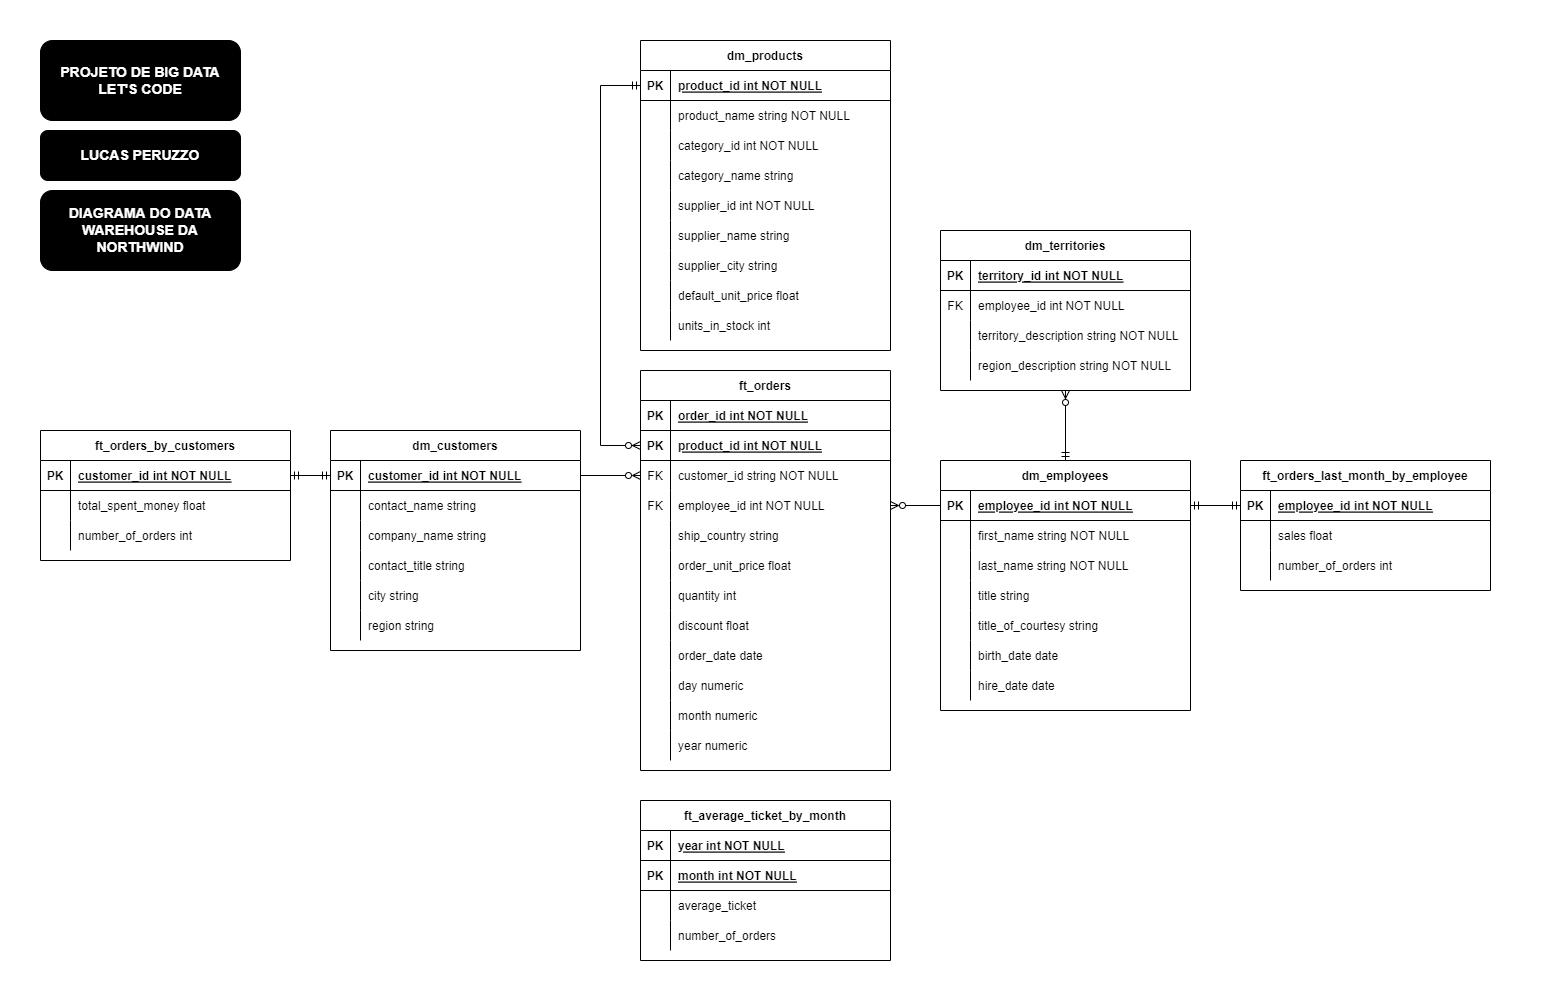

#### 6.1.1 TABELA ft_orders

In [0]:
ft_orders = spark.sql(
                    f"""
                        select 
                        orders_trusted.order_id,
                        order_details_trusted.product_id,
                        orders_trusted.customer_id,
                        orders_trusted.employee_id,
                        orders_trusted.ship_country,
                        order_details_trusted.unit_price AS order_unit_price,
                        order_details_trusted.quantity,
                        order_details_trusted.discount,
                        orders_trusted.order_date,
                        EXTRACT (DAY FROM orders_trusted.order_date) as day,
                        EXTRACT (MONTH FROM orders_trusted.order_date) as month,
                        EXTRACT (YEAR FROM orders_trusted.order_date) as year
                        from orders_trusted
                        left join order_details_trusted ON orders_trusted.order_id = order_details_trusted.order_id;
                    """)

# Gravar os arquivos Delta
(ft_orders.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/ft_orders"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS ft_orders
""")
spark.sql(f"""
CREATE TABLE ft_orders
USING DELTA
LOCATION "{northwind}/refined/ft_orders"
""")

display(spark.sql(f"""select * from ft_orders"""))

order_id,product_id,customer_id,employee_id,ship_country,order_unit_price,quantity,discount,order_date,day,month,year
10248,72,VINET,5,France,34.8,5,0.0,1996-07-04,4,7,1996
10248,42,VINET,5,France,9.8,10,0.0,1996-07-04,4,7,1996
10248,11,VINET,5,France,14.0,12,0.0,1996-07-04,4,7,1996
10249,51,TOMSP,6,Germany,42.4,40,0.0,1996-07-05,5,7,1996
10249,14,TOMSP,6,Germany,18.6,9,0.0,1996-07-05,5,7,1996
10250,65,HANAR,4,Brazil,16.8,15,0.15,1996-07-08,8,7,1996
10250,51,HANAR,4,Brazil,42.4,35,0.15,1996-07-08,8,7,1996
10250,41,HANAR,4,Brazil,7.7,10,0.0,1996-07-08,8,7,1996
10251,65,VICTE,3,France,16.8,20,0.0,1996-07-08,8,7,1996
10251,57,VICTE,3,France,15.6,15,0.05,1996-07-08,8,7,1996


#### 6.1.2 TABELA dm_products

In [0]:
dm_products = spark.sql(
                    f"""
                        select 
                        products_trusted.product_id,
                        products_trusted.product_name,
                        categories_trusted.category_id,
                        categories_trusted.category_name,
                        suppliers_trusted.supplier_id,
                        suppliers_trusted.contact_name AS supplier_name,
                        suppliers_trusted.city AS supplier_city,
                        products_trusted.unit_price AS default_unit_price
                        from products_trusted
                        left join categories_trusted ON products_trusted.category_id = categories_trusted.category_id
                        left join suppliers_trusted ON products_trusted.supplier_id = suppliers_trusted.supplier_id
                    """)

# Gravar os arquivos Delta
(dm_products.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/dm_products"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS dm_products
""")
spark.sql(f"""
CREATE TABLE dm_products
USING DELTA
LOCATION "{northwind}/refined/dm_products"
""")

display(spark.sql(f"""select * from dm_products"""))

product_id,product_name,category_id,category_name,supplier_id,supplier_name,supplier_city,default_unit_price
1,Chai,1,Beverages,8,Peter Wilson,Manchester,18.0
2,Chang,1,Beverages,1,Charlotte Cooper,London,19.0
3,Aniseed Syrup,2,Condiments,1,Charlotte Cooper,London,10.0
4,Chef Anton's Cajun Seasoning,2,Condiments,2,Shelley Burke,New Orleans,22.0
5,Chef Anton's Gumbo Mix,2,Condiments,2,Shelley Burke,New Orleans,21.35
6,Grandma's Boysenberry Spread,2,Condiments,3,Regina Murphy,Ann Arbor,25.0
7,Uncle Bob's Organic Dried Pears,7,Produce,3,Regina Murphy,Ann Arbor,30.0
8,Northwoods Cranberry Sauce,2,Condiments,3,Regina Murphy,Ann Arbor,40.0
9,Mishi Kobe Niku,6,Meat/Poultry,4,Yoshi Nagase,Tokyo,97.0
10,Ikura,8,Seafood,4,Yoshi Nagase,Tokyo,31.0


#### 6.1.3 TABELA dm_territories

In [0]:
dm_territories = spark.sql(
                    f"""
                        select 
                        territories_trusted.territory_id,
                        employee_territories_trusted.employee_id,
                        territories_trusted.territory_description,
                        territories_trusted.region_id,
                        region_trusted.region_description
                        from territories_trusted
                        left join employee_territories_trusted ON territories_trusted.territory_id = employee_territories_trusted.territory_id
                        left join region_trusted ON territories_trusted.region_id = region_trusted.region_id
                    """)

# Gravar os arquivos Delta
(dm_territories.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/dm_territories"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS dm_territories
""")
spark.sql(f"""
CREATE TABLE dm_territories
USING DELTA
LOCATION "{northwind}/refined/dm_territories"
""")

display(spark.sql(f"""select * from dm_territories"""))

territory_id,employee_id,territory_description,region_id,region_description
1581,2,Westboro,1,Eastern
1730,2,Bedford,1,Eastern
1833,2,Georgetow,1,Eastern
2116,2,Boston,1,Eastern
2139,2,Cambridge,1,Eastern
2184,2,Braintree,1,Eastern
2903,5,Providence,1,Eastern
3049,9,Hollis,3,Northern
3801,9,Portsmouth,3,Northern
6897,1,Wilton,1,Eastern


#### 6.1.4 TABELA dm_customers

In [0]:
dm_customers = spark.sql(
                    f"""
                        select 
                        customer_id,
                        contact_name,
                        company_name,
                        contact_title,
                        city,
                        region
                        from customers_trusted
                    """)

# Gravar os arquivos Delta
(dm_customers.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/dm_customers"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS dm_customers
""")
spark.sql(f"""
CREATE TABLE dm_customers
USING DELTA
LOCATION "{northwind}/refined/dm_customers"
""")

display(spark.sql(f"""select * from dm_customers"""))

customer_id,contact_name,company_name,contact_title,city,region
ALFKI,Maria Anders,Alfreds Futterkiste,Sales Representative,Berlin,null
ANATR,Ana Trujillo,Ana Trujillo Emparedados y helados,Owner,México D.F.,null
ANTON,Antonio Moreno,Antonio Moreno Taquería,Owner,México D.F.,null
AROUT,Thomas Hardy,Around the Horn,Sales Representative,London,null
BERGS,Christina Berglund,Berglunds snabbköp,Order Administrator,Luleå,null
BLAUS,Hanna Moos,Blauer See Delikatessen,Sales Representative,Mannheim,null
BLONP,Frédérique Citeaux,Blondesddsl père et fils,Marketing Manager,Strasbourg,null
BOLID,Martín Sommer,Bólido Comidas preparadas,Owner,Madrid,null
BONAP,Laurence Lebihan,Bon app',Owner,Marseille,null
BOTTM,Elizabeth Lincoln,Bottom-Dollar Markets,Accounting Manager,Tsawassen,BC


#### 6.1.5 TABELA dm_employees

In [0]:
dm_employees = spark.sql(
                    f"""
                        select 
                        employee_id,
                        first_name,
                        last_name,
                        title,
                        title_of_courtesy,
                        birth_date,
                        hire_date
                        from employees_trusted
                    """)
# Gravar os arquivos Delta
(dm_employees.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/dm_employees"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS dm_employees
""")
spark.sql(f"""
CREATE TABLE dm_employees
USING DELTA
LOCATION "{northwind}/refined/dm_employees"
""")

display(spark.sql(f"""select * from dm_employees"""))

employee_id,first_name,last_name,title,title_of_courtesy,birth_date,hire_date
1,Nancy,Davolio,Sales Representative,Ms.,1948-12-08,1992-05-01
2,Andrew,Fuller,"Vice President, Sales",Dr.,1952-02-19,1992-08-14
3,Janet,Leverling,Sales Representative,Ms.,1963-08-30,1992-04-01
4,Margaret,Peacock,Sales Representative,Mrs.,1937-09-19,1993-05-03
5,Steven,Buchanan,Sales Manager,Mr.,1955-03-04,1993-10-17
6,Michael,Suyama,Sales Representative,Mr.,1963-07-02,1993-10-17
7,Robert,King,Sales Representative,Mr.,1960-05-29,1994-01-02
8,Laura,Callahan,Inside Sales Coordinator,Ms.,1958-01-09,1994-03-05
9,Anne,Dodsworth,Sales Representative,Ms.,1966-01-27,1994-11-15


#### 6.1.6 TABELA ft_orders_by_customers

In [0]:
ft_orders_by_customers = spark.sql(
                    f"""
                        select
                        customer_id,
                        sum(quantity*order_unit_price-discount) as total_spent_money,
                        count(order_id) as number_of_orders
                        from ft_orders
                        group by customer_id
                    """)

# Gravar os arquivos Delta
(ft_orders_by_customers.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/ft_orders_by_customers"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS ft_orders_by_customers
""")
spark.sql(f"""
CREATE TABLE ft_orders_by_customers
USING DELTA
LOCATION "{northwind}/refined/ft_orders_by_customers"
""")

display(spark.sql(f"""select * from ft_orders_by_customers"""))

customer_id,total_spent_money,number_of_orders
WOLZA,3531.9499740600586,16
MAISD,10429.579940795898,17
BLAUS,3239.7999877929688,14
MAGAA,7602.799976348877,21
FOLKO,32551.699741363525,45
ANATR,1402.9500007629395,10
ISLAT,6146.300003051758,23
VAFFE,16642.799911499023,31
CENTC,100.79999923706055,2
BLONP,19087.249977111816,26


#### 6.1.7 TABELA ft_orders_last_month_by_employee

In [0]:
ft_orders_last_month_by_employee = spark.sql(
                    f"""
                        select
                        employee_id,
                        sum(quantity*order_unit_price-discount) as sales,
                        count(order_id) as number_of_orders
                        from ft_orders
                        where ft_orders.month = (select EXTRACT(month FROM order_date) as month from ft_orders order by order_date DESC limit 1) 
                        and ft_orders.year = (select EXTRACT(year FROM order_date) as year from ft_orders order by order_date DESC limit 1)
                        group by employee_id
                    """)

# Gravar os arquivos Delta
(ft_orders_last_month_by_employee.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/ft_orders_last_month_by_employee"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS ft_orders_last_month_by_employee
""")
spark.sql(f"""
CREATE TABLE ft_orders_last_month_by_employee
USING DELTA
LOCATION "{northwind}/refined/ft_orders_last_month_by_employee"
""")

display(spark.sql(f"""select * from ft_orders_last_month_by_employee"""))


employee_id,sales,number_of_orders
1,7052.659925460815,34
4,6274.25,7
8,3221.9599838256836,8
7,1173.0000114440918,4
2,2173.0499572753906,6


#### 6.1.8 TABELA ft_average_ticket_by_month

In [0]:
ft_average_ticket_by_month = spark.sql(
                    f"""
                        select
                        year,
                        month,
                        avg(quantity*order_unit_price-discount) as average_ticket,
                        count(order_id) as number_of_orders
                        from ft_orders
                        group by year, month
                    """)
ft_average_ticket_by_month = ft_average_ticket_by_month.orderBy("year","month")

# Gravar os arquivos Delta
(ft_average_ticket_by_month.write
 .format("delta")
 .mode("overwrite")
 .save(northwind + "refined/ft_average_ticket_by_month"))

# Registrar a Tabela Delta no Metastore
spark.sql(f"""
DROP TABLE IF EXISTS ft_average_ticket_by_month
""")
spark.sql(f"""
CREATE TABLE ft_average_ticket_by_month
USING DELTA
LOCATION "{northwind}/refined/ft_average_ticket_by_month"
""")

display(spark.sql(f"""select * from ft_average_ticket_by_month"""))

year,month,average_ticket,number_of_orders
1996,7,511.66779670068775,59
1996,8,385.6043463859005,69
1996,9,484.81754366556805,57
1996,10,564.3671267783806,73
1996,11,753.0469685178814,66
1996,12,628.9802494755497,81
1997,1,784.5558830934413,85
1997,2,521.5398725920086,79
1997,3,519.1720787518984,77
1997,4,687.595554869852,81
